In [5]:
import pandas as pd

from statistics import mean
import statistics
import numpy as np
import os
import subprocess
import re
import json
from tabulate import tabulate


import matplotlib.pyplot as plt
import seaborn as sns
from math import nan

In [6]:

with open("all_ast_results.json", "r") as fd:
    results = json.load(fd)

#################

func_results = {}


for data in results:
    opt = data["opt"]
    filename = data["filename"]
    for func, result in data["results"].items():
        func_name = f'{filename}:{func}:O{opt}'
        if func_name not in func_results:
            func_results[func_name] = {}
        for tool in ["w2c2", "wasm2c", "ghidra", 'retdec']:
            try:
                func_results[func_name][tool] = { "opt": int(opt),
                                 "nqc": result[tool]["nqc"], 
                                 "ted": result[tool]["ted"]}
            except:
                print(opt, tool, func_name, result)
                print()
            #if result[tool]["ted"]< 0 and opt != 2:
            #    print(opt, tool, func_name)

func_names = []
rows = []
for func_name, columns in func_results.items():
    func_names.append(func_name)
    rows.append(columns)
        
d = pd.json_normalize(rows)
df_sym = pd.DataFrame(d)
df_sym.columns = df_sym.columns.str.split('.', expand=True)
# print(df.loc[0])
df_sym["func"] = func_names
df_sym = df_sym.set_index("func")

#pd.set_option('display.max_rows', None)
#display(df['ghidra'])
#pd.reset_option('display.max_rows')



#####



for metrix in ["nqc", "ted"]:
    table = [
        ["metrix", "Tool", "Opt", "Total func", "AVG", "STD"]
    ]
    for tool in ["w2c2", "wasm2c", "ghidra", 'retdec']:
        for opt in [0,1,2]:
            opt_tool_df = df_sym[tool][(df_sym[tool]["opt"] == opt)]
            cnt = round(opt_tool_df[(opt_tool_df[metrix] > 0)][metrix].count(), 3)
            avg = round(opt_tool_df[(opt_tool_df[metrix] > 0)][metrix].mean(), 3)
            std = round(opt_tool_df[(opt_tool_df[metrix] > 0)][metrix].std(), 3)
            table.append(
                [metrix, tool, opt, cnt, avg, std]
            )
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))        

╒══════════╤════════╤═══════╤══════════════╤═══════╤═══════╕
│ metrix   │ Tool   │   Opt │   Total func │   AVG │   STD │
╞══════════╪════════╪═══════╪══════════════╪═══════╪═══════╡
│ nqc      │ w2c2   │     0 │          145 │ 0.17  │ 0.206 │
├──────────┼────────┼───────┼──────────────┼───────┼───────┤
│ nqc      │ w2c2   │     1 │          145 │ 0.23  │ 0.195 │
├──────────┼────────┼───────┼──────────────┼───────┼───────┤
│ nqc      │ w2c2   │     2 │          145 │ 0.223 │ 0.201 │
├──────────┼────────┼───────┼──────────────┼───────┼───────┤
│ nqc      │ wasm2c │     0 │          145 │ 0.047 │ 0.022 │
├──────────┼────────┼───────┼──────────────┼───────┼───────┤
│ nqc      │ wasm2c │     1 │          145 │ 0.197 │ 0.14  │
├──────────┼────────┼───────┼──────────────┼───────┼───────┤
│ nqc      │ wasm2c │     2 │          145 │ 0.193 │ 0.147 │
├──────────┼────────┼───────┼──────────────┼───────┼───────┤
│ nqc      │ ghidra │     0 │          145 │ 0.573 │ 0.26  │
├──────────┼────────┼───

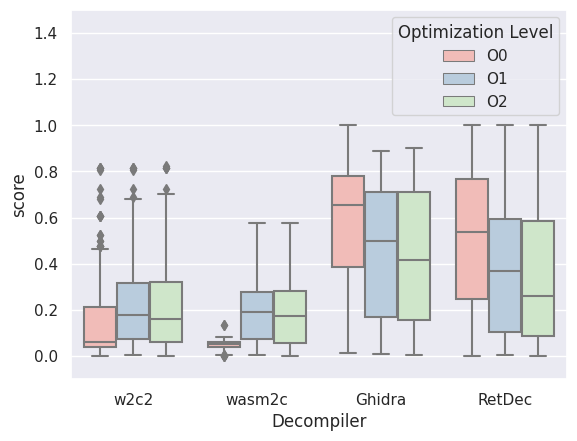

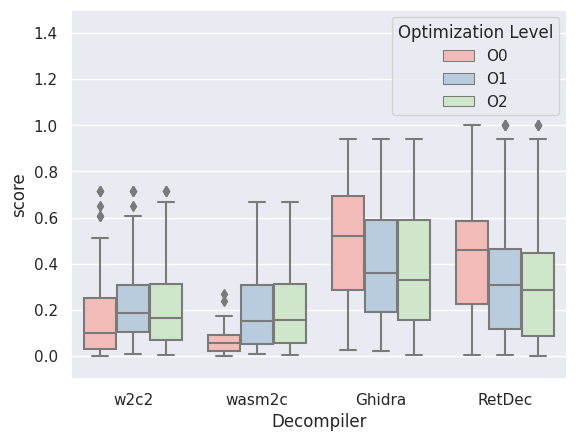

In [7]:
sns.set(style="darkgrid")

for metrics, msg in {"nqc": "Node Quantity Compare",
               "ted": "Tree Edit Distance"
            }.items():
    

    df = pd.DataFrame(columns = ['Decompiler', 'O0', 'O1', 'O2'])
    length = 145


    for tool, tool_name in {
        "w2c2": "w2c2", 
        "wasm2c": "wasm2c", 
        "ghidra": "Ghidra", 
        'retdec': "RetDec"}.items():
        loc_df = pd.DataFrame({
            "Decompiler": [tool_name]*length,
            'O0': df_sym[tool][(df_sym[tool]["opt"] == 0)][metrics].values,
            'O1': df_sym[tool][(df_sym[tool]["opt"] == 1)][metrics].values,
            'O2': df_sym[tool][(df_sym[tool]["opt"] == 2)][metrics].values
        })
        df = pd.concat([df, loc_df], ignore_index = True)




    df = pd.melt(frame = df,
                 id_vars = 'Decompiler',
                 value_vars = ['O0', 'O1', 'O2'],
                 var_name = 'Optimization Level',
                 value_name = msg)


    df[msg] = df[msg].astype(float)

    fig, ax = plt.subplots()

    sns.boxplot(ax = ax,
                   data = df,
                   x = 'Decompiler',
                   y = msg,
                   hue = 'Optimization Level',
                   palette="Pastel1")
    #plt.title(msg)
    ax.set_ylabel("score")
    ax.set_ylim([-0.1, 1.5])
    plt.savefig(f'plots/{msg}.png')
    plt.show()
    

In [10]:
# df_read

with open("all_readability_results.json", "r") as fd:
    rresults = json.load(fd)

    
####

func_rresults = {}


for data in rresults:
    opt = data["opt"]
    filename = data["filename"]
    for func, result in data["results"].items():
        func_name = f'{filename}:{func}:O{opt}'
        if func_name not in func_rresults:
            func_rresults[func_name] = {}
        for tool in ["w2c2", "wasm2c", "ghidra", 'retdec']:
            try:
                func_rresults[func_name][tool] = result[tool]
                func_rresults[func_name][tool]["opt"] = int(opt)
            except:
                print(opt, tool, func_name, result)
                print()
            #if result[tool]["ted"]< 0 and opt != 2:
            #    print(opt, tool, func_name)

func_names = []
rows = []
for func_name, columns in func_rresults.items():
    func_names.append(func_name)
    rows.append(columns)
        
d = pd.json_normalize(rows)
df_read = pd.DataFrame(d)
df_read.columns = df_read.columns.str.split('.', expand=True)
# print(df.loc[0])
df_read["func"] = func_names
df_read = df_read.set_index("func")

#pd.set_option('display.max_rows', None)
#display(df['ghidra'])
#pd.reset_option('display.max_rows')

#####



for metrix in ["Lines of code",
               "# goto",
               "# cast",
               "# var",
               "# dead code"
              ]:
    table = [
        ["Tool", "Opt", 
         "AVG", 
         "SUM", 
         #"STD"
        ]
    ]
    print(metrix)
    for tool in ["w2c2", "wasm2c", "ghidra", 'retdec']:
        for opt in [0,1,2]:
            opt_tool_df = df_read[tool][(df_read[tool]["opt"] == opt)]
            avg = round(opt_tool_df[metrix].mean(), 3)
            ss = round(opt_tool_df[metrix].sum(), 3)
            std = round(opt_tool_df[metrix].std(), 3)
            table.append(
                [tool, opt, 
                 avg, 
                 ss, 
                 #std
                ]
            )
    
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))     
    


for metrix in [
               "Maximum nesting depth",
               "Halstead complexity difficulty measure",
               "McCabe cyclomatic complexity"
              ]:
    table = [
        ["Tool", "Opt", 
         "AVG", 
         #"SUM", 
         "STD"]
    ]
    print(metrix)
    for tool in ["w2c2", "wasm2c", "ghidra", 'retdec']:
        for opt in [0,1,2]:
            opt_tool_df = df_read[tool][(df_read[tool]["opt"] == opt)]
            avg = round(opt_tool_df[metrix].mean(), 3)
            ss = round(opt_tool_df[metrix].sum(), 3)
            std = round(opt_tool_df[metrix].std(), 3)
            table.append(
                [tool, opt, 
                 avg, 
                 #ss, 
                 std
                ]
            )
    
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))       


Lines of code
╒════════╤═══════╤═════════╤═══════╕
│ Tool   │   Opt │     AVG │   SUM │
╞════════╪═══════╪═════════╪═══════╡
│ w2c2   │     0 │ 513.607 │ 74473 │
├────────┼───────┼─────────┼───────┤
│ w2c2   │     1 │ 171.228 │ 24828 │
├────────┼───────┼─────────┼───────┤
│ w2c2   │     2 │ 189.241 │ 27440 │
├────────┼───────┼─────────┼───────┤
│ wasm2c │     0 │ 499.048 │ 72362 │
├────────┼───────┼─────────┼───────┤
│ wasm2c │     1 │ 195.393 │ 28332 │
├────────┼───────┼─────────┼───────┤
│ wasm2c │     2 │ 210.076 │ 30461 │
├────────┼───────┼─────────┼───────┤
│ ghidra │     0 │  33.228 │  4818 │
├────────┼───────┼─────────┼───────┤
│ ghidra │     1 │  51.634 │  7487 │
├────────┼───────┼─────────┼───────┤
│ ghidra │     2 │  63.786 │  9249 │
├────────┼───────┼─────────┼───────┤
│ retdec │     0 │  71.559 │ 10376 │
├────────┼───────┼─────────┼───────┤
│ retdec │     1 │  77.862 │ 11290 │
├────────┼───────┼─────────┼───────┤
│ retdec │     2 │ 107.414 │ 15575 │
╘════════╧═══════╧══════

In [11]:
with open("readability_entries.json", "r") as fd:
    entries = json.load(fd)

with open("metrics/results/new/em_output_src.json", "r") as fd:
    rresults = json.load(fd)

    
####

func_rresults = {}


for entry in entries:
    if entry["opt"] != 0:
        continue
    filename = entry["filename"]
    if filename.startswith("PL_"):
        filename = filename.replace("PL_", "")
    functions = entry["functions"]
    for func in functions:
        try:
            func_name = f'{filename}:{func}'
            if func_name not in func_rresults:
                func_rresults[func_name] = {}
            for key, data in rresults[filename+".c"].items():
                func_rresults[func_name][key] = data[func]
        except:
            print(filename, func, key)


func_names = []
rows = []
for func_name, columns in func_rresults.items():
    func_names.append(func_name)
    rows.append(columns)
        
d = pd.json_normalize(rows)
df_orig = pd.DataFrame(d)
df_orig.columns = df_orig.columns.str.split('.', expand=True)
# print(df.loc[0])
df_orig["func"] = func_names
df_orig = df_orig.set_index("func")

#pd.set_option('display.max_rows', None)
#display(df)
#pd.reset_option('display.max_rows')

#####


tool = "orig"

for metrix in ["Lines of code",
               "# goto",
               "# cast",
               "# var",
               "# dead code"
              ]:
    table = [
        ["Tool", 
         "AVG", 
         "SUM", 
         #"STD"
        ]
    ]
    print(metrix)
    avg = round(df_orig[metrix].mean(), 3)
    ss = round(df_orig[metrix].sum(), 3)
    std = round(df_orig[metrix].std(), 3)
    table.append(
        [tool, 
         avg, 
         ss, 
         #std
        ]
    )

    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))     
    


for metrix in [
               "Maximum nesting depth",
               "Halstead complexity difficulty measure",
               "McCabe cyclomatic complexity"
              ]:
    table = [
        ["Tool", 
         "AVG", 
         #"SUM", 
         "STD"]
    ]
    print(metrix)
    avg = round(df_orig[metrix].mean(), 3)
    ss = round(df_orig[metrix].sum(), 3)
    std = round(df_orig[metrix].std(), 3)
    table.append(
        [tool, 
         avg, 
         #ss, 
         std
        ]
    )
    
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Lines of code
╒════════╤════════╤═══════╕
│ Tool   │    AVG │   SUM │
╞════════╪════════╪═══════╡
│ orig   │ 18.062 │  2619 │
╘════════╧════════╧═══════╛
# goto
╒════════╤═══════╤═══════╕
│ Tool   │   AVG │   SUM │
╞════════╪═══════╪═══════╡
│ orig   │     0 │     0 │
╘════════╧═══════╧═══════╛
# cast
╒════════╤═══════╤═══════╕
│ Tool   │   AVG │   SUM │
╞════════╪═══════╪═══════╡
│ orig   │ 0.269 │    39 │
╘════════╧═══════╧═══════╛
# var
╒════════╤═══════╤═══════╕
│ Tool   │   AVG │   SUM │
╞════════╪═══════╪═══════╡
│ orig   │ 1.338 │   194 │
╘════════╧═══════╧═══════╛
# dead code
╒════════╤═══════╤═══════╕
│ Tool   │   AVG │   SUM │
╞════════╪═══════╪═══════╡
│ orig   │ 0.028 │     4 │
╘════════╧═══════╧═══════╛
Maximum nesting depth
╒════════╤═══════╤═══════╕
│ Tool   │   AVG │   STD │
╞════════╪═══════╪═══════╡
│ orig   │ 0.952 │ 1.163 │
╘════════╧═══════╧═══════╛
Halstead complexity difficulty measure
╒════════╤════════╤════════╕
│ Tool   │    AVG │    STD │
╞════════╪════════╪═

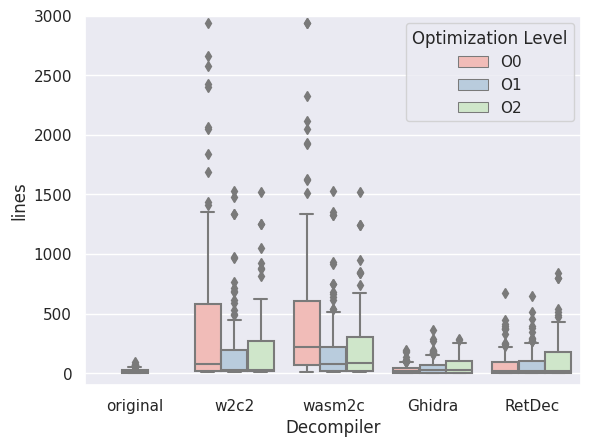

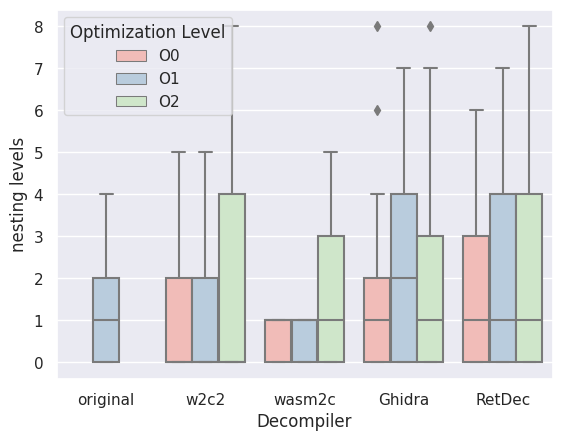

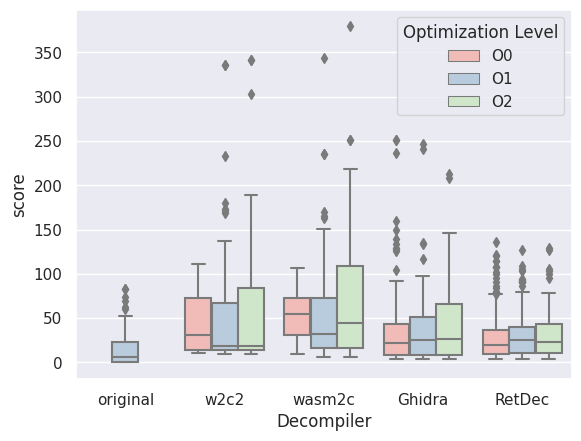

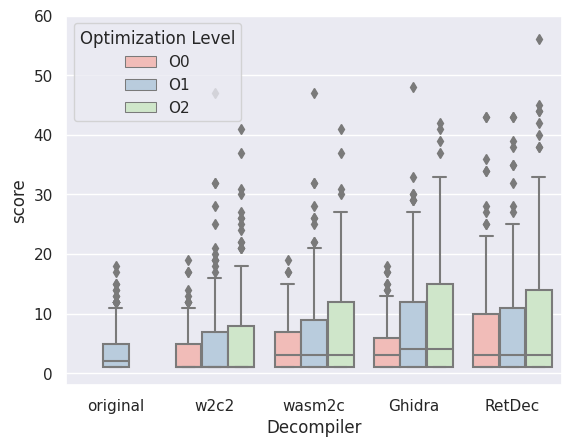

In [13]:
sns.set(style="darkgrid")

for metrics, msg in {"Lines of code": "Line of Code",
               "Maximum nesting depth": "Maximum Nesting Depth",
               "Halstead complexity difficulty measure": "Halstead Complexity Measure",
               "McCabe cyclomatic complexity": "Cyclomatic Complexity"
            }.items():
    

    df = pd.DataFrame(columns = ['Decompiler', 'O0', 'O1', 'O2'])
    length = len(df_orig[metrics])


    loc_df = pd.DataFrame({
        "Decompiler": ["original"]*length,
        'O0': [nan]*length,
        'O1': df_orig[metrics].values,
        'O2': [nan]*length
    })
    df = pd.concat([df, loc_df], ignore_index = True)

    for tool, tool_name in {
        "w2c2": "w2c2", 
        "wasm2c": "wasm2c", 
        "ghidra": "Ghidra", 
        'retdec': "RetDec"}.items():
        loc_df = pd.DataFrame({
            "Decompiler": [tool_name]*length,
            'O0': df_read[tool][(df_read[tool]["opt"] == 0)][metrics].values,
            'O1': df_read[tool][(df_read[tool]["opt"] == 1)][metrics].values,
            'O2': df_read[tool][(df_read[tool]["opt"] == 2)][metrics].values
        })
        df = pd.concat([df, loc_df], ignore_index = True)




    df = pd.melt(frame = df,
                 id_vars = 'Decompiler',
                 value_vars = ['O0', 'O1', 'O2'],
                 var_name = 'Optimization Level',
                 value_name = msg)


    df[msg] = df[msg].astype(float)

    fig, ax = plt.subplots()

    sns.boxplot(ax = ax,
                   data = df,
                   x = 'Decompiler',
                   y = msg,
                   hue = 'Optimization Level',
                   palette="Pastel1")
    
    if metrics == "Lines of code":
        plt.ylim([-100,3000])
        ax.set_ylabel("lines")
    elif metrics == "Maximum nesting depth":
        ax.set_ylabel("nesting levels")
    elif metrics == "McCabe cyclomatic complexity":
        plt.ylim([-2,60])
        ax.set_ylabel("score")
    else:
        ax.set_ylabel("score")
    #plt.title(msg)
    plt.savefig(f'plots/{msg}.png')
    plt.show()
    

In [ ]:
# Below is example code

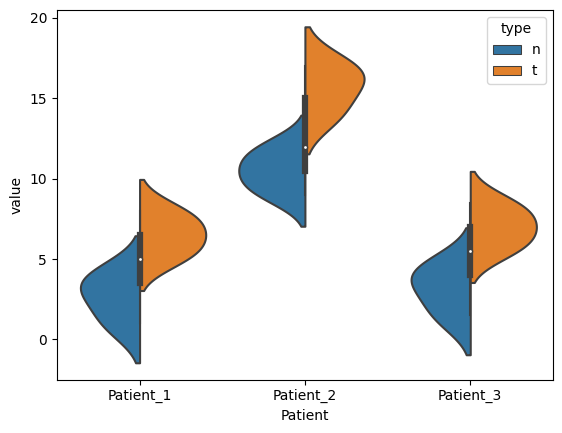

In [55]:
paired_patients = {'Patient_1': {'n': [1, nan, 3, 4], 't': [5, 6, 7, 8]},
                   'Patient_2': {'n': [9, 10, 11, 12], 't': [14, nan, 16, 17]},
                   'Patient_3': {'n': [1.5, nan, 3.5, 4.5], 't': [5.5, 6.5, 7.5, 8.5]}}

df = pd.DataFrame(columns = ['Patient', 'n', 't'])

for key, value in paired_patients.items():
    patient_df = pd.DataFrame({'Patient': [key]*len(value['n']),
                               'n': value['n'],
                               't': value['t']})
    df = pd.concat([df, patient_df], ignore_index = True)

df = pd.melt(frame = df,
             id_vars = 'Patient',
             value_vars = ['n', 't'],
             var_name = 'type',
             value_name = 'value')

df['value'] = df['value'].astype(float)

fig, ax = plt.subplots()

sns.violinplot(ax = ax,
               data = df,
               x = 'Patient',
               y = 'value',
               hue = 'type',
               split = True)

plt.show()